In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import warnings

Для лабораторной работы был выбран набор данных, собранный на двух солнечных электростанциях в Индии в течение 34 дней

https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data

In [32]:
warnings.filterwarnings("ignore")

In [33]:
data = pd.read_csv('../data/Plant_1_Generation_Data.csv', parse_dates=['DATE_TIME'], dayfirst=True)
data.set_index('DATE_TIME', inplace=True)

In [34]:
data.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [35]:
data.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


In [36]:
hourly_data = data[['DC_POWER']].resample('h').mean()

In [37]:
hourly_data.head(24)

,DC_POWER
DATE_TIME,
2020-05-15 00:00:00,0.000000
2020-05-15 01:00:00,0.000000
2020-05-15 02:00:00,0.000000
2020-05-15 03:00:00,0.000000
2020-05-15 04:00:00,0.000000
2020-05-15 05:00:00,0.000000
2020-05-15 06:00:00,592.813884
2020-05-15 07:00:00,1976.423945
2020-05-15 08:00:00,4220.533983


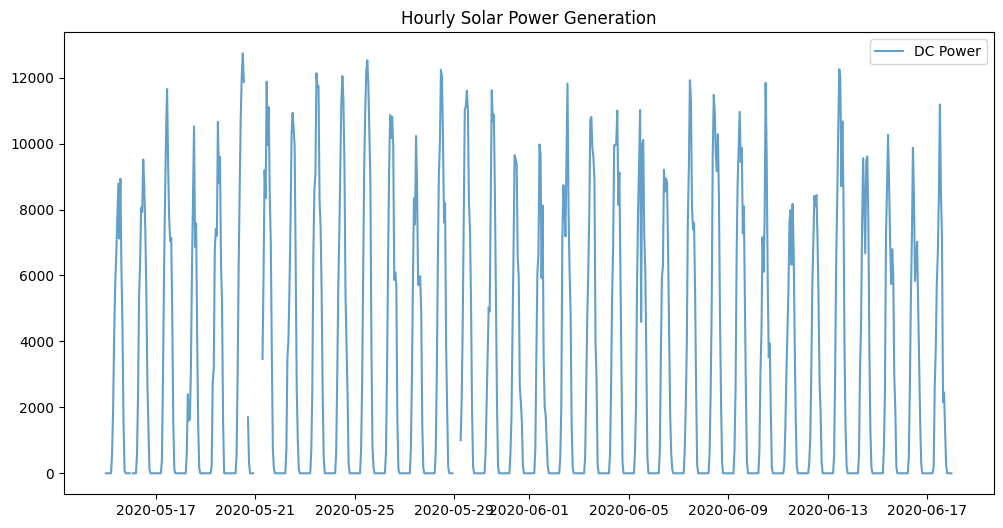

In [38]:
# Визуализация 'DC_POWER' по часам
plt.figure(figsize=(12, 6))
plt.plot(hourly_data['DC_POWER'], label='DC Power', alpha=0.7)
plt.title('Hourly Solar Power Generation')
plt.legend()
plt.show()

In [39]:
# Проверка наличия пропущенных значений
print(hourly_data.isna().sum())

# Заполнение пропущенных значений линейной интерполяцией
hourly_data['DC_POWER'] = hourly_data['DC_POWER'].interpolate(method='linear')

DC_POWER    20
dtype: int64


In [40]:
# Заполнение пропущенных значений линейной интерполяцией
hourly_data['DC_POWER'] = hourly_data['DC_POWER'].interpolate(method='linear')

In [41]:
from statsmodels.tsa.stattools import adfuller


# Функция для выполнения теста Дики-Фуллера и вывода результатов
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")


# Выполняем тест для исходного ряда DC_POWER
print("Проверка на стационарность для исходного временного ряда DC_POWER")
adf_test(hourly_data['DC_POWER'])

Проверка на стационарность для исходного временного ряда DC_POWER
ADF Statistic: -4.29556467748414
p-value: 0.00045213427590680015
Critical Values:
   1%: -3.4386126789104074
   5%: -2.865186972298872
   10%: -2.5687119871327146


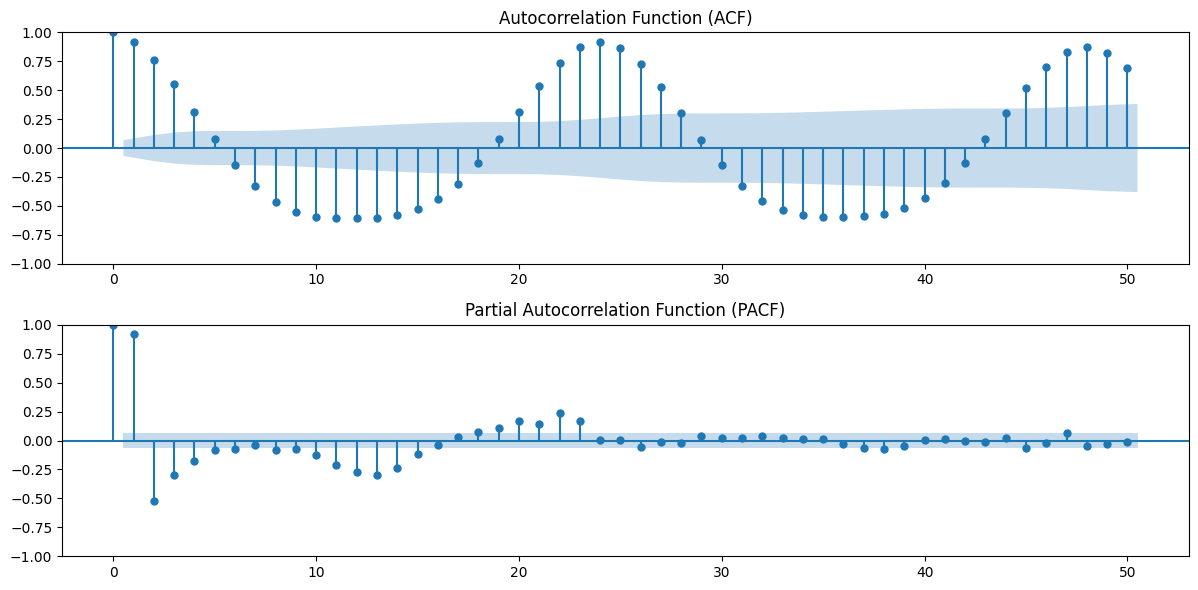

In [42]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(hourly_data['DC_POWER'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(hourly_data['DC_POWER'], lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Сезонность составляет 24 часа.
Всего периодов 34.

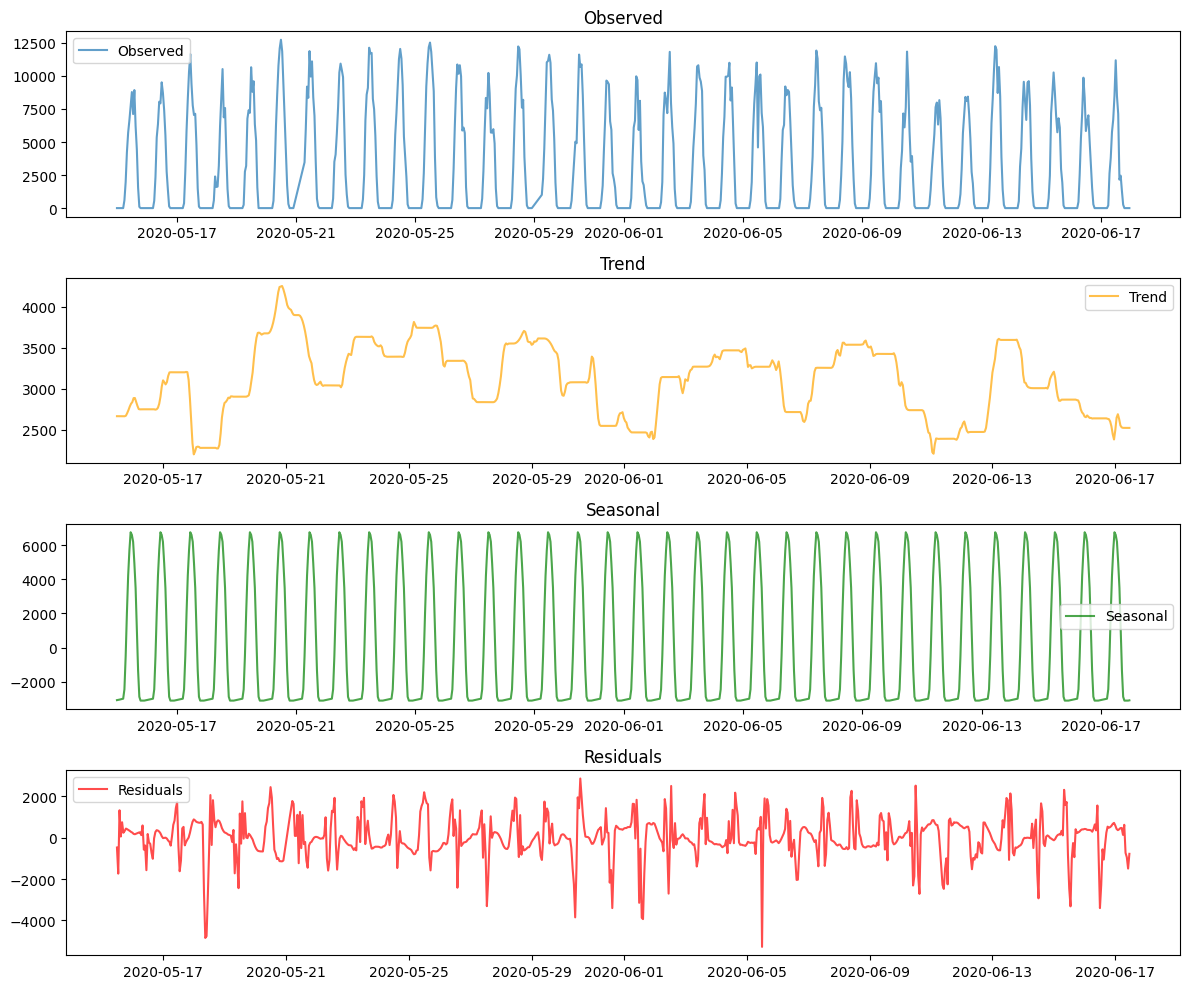

In [43]:
result = seasonal_decompose(hourly_data['DC_POWER'], model='additive', period=24)

# Визуализация результатов разложения
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed', alpha=0.7)
plt.title('Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange', alpha=0.7)
plt.title('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green', alpha=0.7)
plt.title('Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals', color='red', alpha=0.7)
plt.title('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# Разделение данных на обучающую и тестовую выборки (учет двух периодов вперед)
forecast_horizon = 48  # Два периода по 24 часа
train_size = len(hourly_data) - forecast_horizon
train_data = hourly_data[:train_size]
test_data = hourly_data[train_size:]

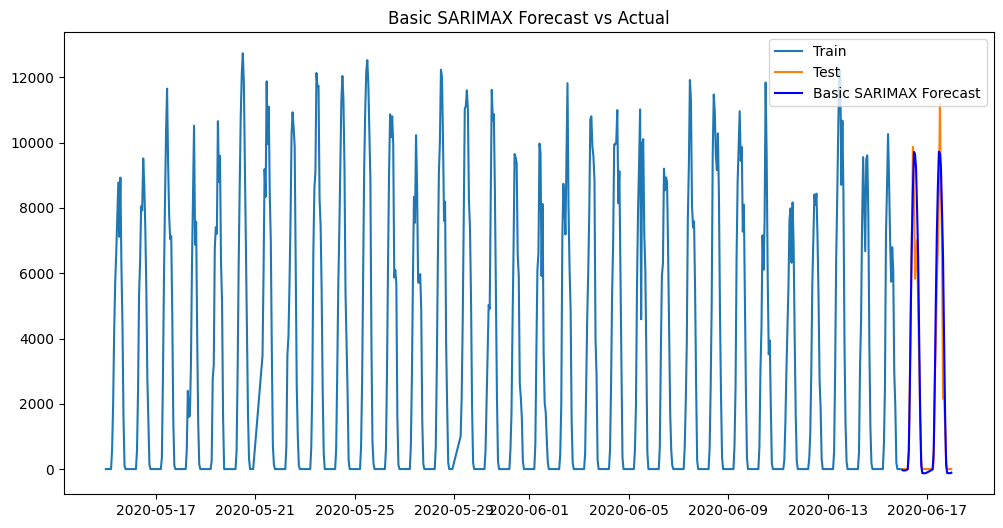

Basic SARIMAX Mean Absolute Error (MAE): 634.9381483090841
Basic SARIMAX Mean Squared Error (MSE): 1306764.600673924
Basic SARIMAX Root Mean Squared Error (RMSE): 1143.1380497008768


In [45]:
#SARIMAX без тюнинга
sarimax_model_basic = SARIMAX(train_data['DC_POWER'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24), 
                              enforce_stationarity=False, enforce_invertibility=False)
sarimax_result_basic = sarimax_model_basic.fit(disp=False)

# Прогноз SARIMAX без тюнинга
forecast_basic = sarimax_result_basic.get_forecast(steps=len(test_data))
forecast_values_basic = forecast_basic.predicted_mean

# Построение графиков для SARIMAX без тюнинга
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['DC_POWER'], label='Train')
plt.plot(test_data.index, test_data['DC_POWER'], label='Test')
plt.plot(test_data.index, forecast_values_basic, label='Basic SARIMAX Forecast', color='blue')
plt.title('Basic SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

# Метрики точности для SARIMAX без тюнинга
mae_sarimax_basic = mean_absolute_error(test_data['DC_POWER'], forecast_values_basic)
mse_sarimax_basic = mean_squared_error(test_data['DC_POWER'], forecast_values_basic)
rmse_sarimax_basic = np.sqrt(mse_sarimax_basic)

print(f"Basic SARIMAX Mean Absolute Error (MAE): {mae_sarimax_basic}")
print(f"Basic SARIMAX Mean Squared Error (MSE): {mse_sarimax_basic}")
print(f"Basic SARIMAX Root Mean Squared Error (RMSE): {rmse_sarimax_basic}")


Тюнинг SARIMAX с помощью auto_arima
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=14893.064, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=13066.728, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=13741.486, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=15267.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=13460.462, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=13264.590, Time=0.96 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=6.60 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=13071.275, Time=2.32 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=13068.332, Time=1.50 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=13155.935, Time=1.17 sec

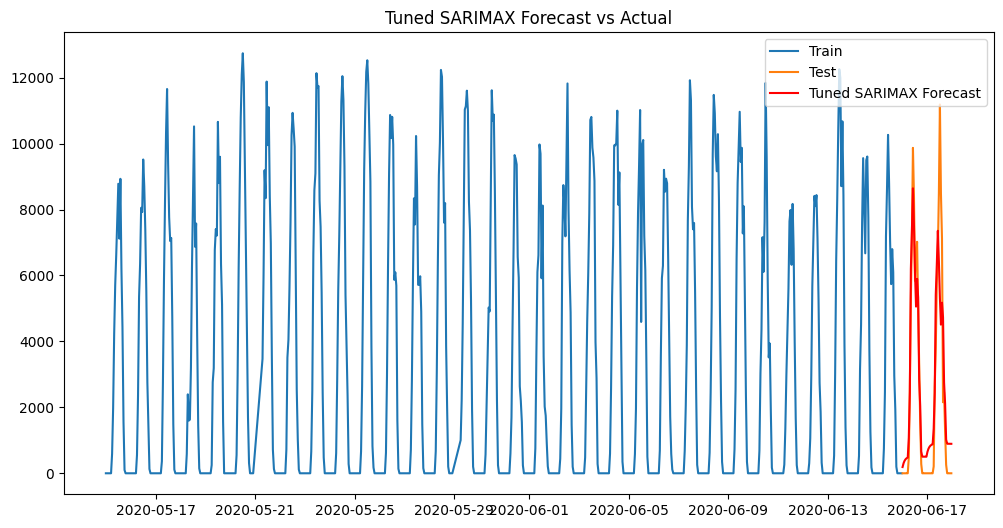

Tuned SARIMAX Mean Absolute Error (MAE): 934.8350808420752
Tuned SARIMAX Mean Squared Error (MSE): 1850029.5985637966
Tuned SARIMAX Root Mean Squared Error (RMSE): 1360.1579314784724


In [46]:
# Подбор параметров SARIMAX с помощью auto_arima
print("Тюнинг SARIMAX с помощью auto_arima")
sarimax_model_tuned = auto_arima(train_data['DC_POWER'],
                                 seasonal=True,
                                 m=24,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 trace=True)

print("Оптимальные параметры:", sarimax_model_tuned.order, sarimax_model_tuned.seasonal_order)

# Модель SARIMAX
sarimax_model = SARIMAX(train_data['DC_POWER'], 
                        order=sarimax_model_tuned.order, 
                        seasonal_order=sarimax_model_tuned.seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit(disp=False)

# Прогноз на тестовой выборке
forecast = sarimax_result.get_forecast(steps=len(test_data))
forecast_index = test_data.index
forecast_values = forecast.predicted_mean

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['DC_POWER'], label='Train')
plt.plot(test_data.index, test_data['DC_POWER'], label='Test')
plt.plot(forecast_index, forecast_values, label='Tuned SARIMAX Forecast', color='red')
plt.title('Tuned SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

# Метрики точности
mae_sarimax = mean_absolute_error(test_data['DC_POWER'], forecast_values)
mse_sarimax = mean_squared_error(test_data['DC_POWER'], forecast_values)
rmse_sarimax = np.sqrt(mse_sarimax)

print(f"Tuned SARIMAX Mean Absolute Error (MAE): {mae_sarimax}")
print(f"Tuned SARIMAX Mean Squared Error (MSE): {mse_sarimax}")
print(f"Tuned SARIMAX Root Mean Squared Error (RMSE): {rmse_sarimax}")

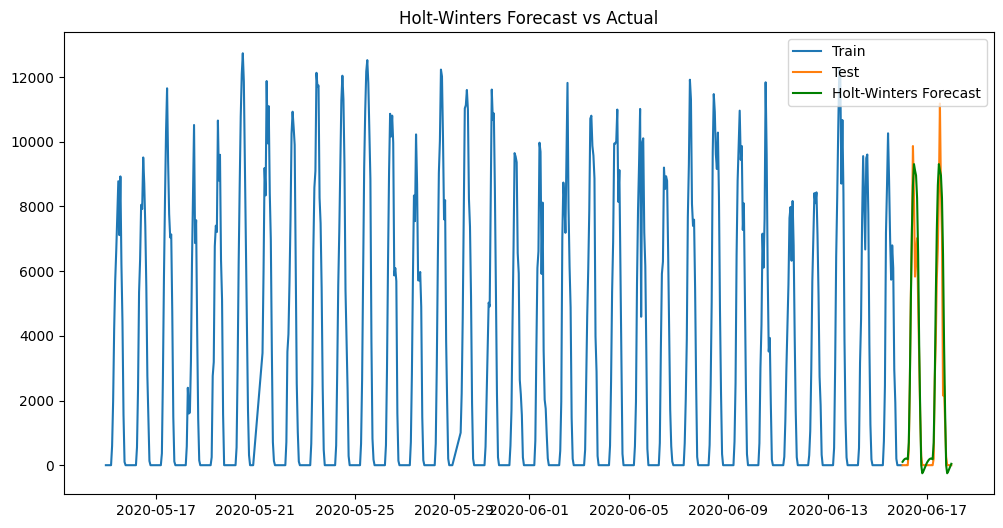

Holt-Winters Mean Absolute Error (MAE): 655.2928031292239
Holt-Winters Mean Squared Error (MSE): 1231105.7900826782
Holt-Winters Root Mean Squared Error (RMSE): 1109.5520673148594

Comparison of Models:
Basic SARIMAX RMSE: 1143.1380497008768
Tuned SARIMAX RMSE: 1360.1579314784724
Holt-Winters RMSE: 1109.5520673148594


In [47]:
# Модель Хольта-Уинтерса
holt_winters_model = ExponentialSmoothing(train_data['DC_POWER'], 
                                           seasonal='add', 
                                           seasonal_periods=24).fit()

holt_winters_forecast = holt_winters_model.forecast(len(test_data))

# Построение графиков для Хольта-Уинтерса
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['DC_POWER'], label='Train')
plt.plot(test_data.index, test_data['DC_POWER'], label='Test')
plt.plot(test_data.index, holt_winters_forecast, label='Holt-Winters Forecast', color='green')
plt.title('Holt-Winters Forecast vs Actual')
plt.legend()
plt.show()

# Метрики точности для Хольта-Уинтерса
mae_hw = mean_absolute_error(test_data['DC_POWER'], holt_winters_forecast)
mse_hw = mean_squared_error(test_data['DC_POWER'], holt_winters_forecast)
rmse_hw = np.sqrt(mse_hw)

print(f"Holt-Winters Mean Absolute Error (MAE): {mae_hw}")
print(f"Holt-Winters Mean Squared Error (MSE): {mse_hw}")
print(f"Holt-Winters Root Mean Squared Error (RMSE): {rmse_hw}")

# Сравнение моделей
print("\nComparison of Models:")
print(f"Basic SARIMAX RMSE: {rmse_sarimax_basic}")
print(f"Tuned SARIMAX RMSE: {rmse_sarimax}")
print(f"Holt-Winters RMSE: {rmse_hw}")


Holt-Winters уходит в отрицательные значения, но в целом лучше описывает временной ряд. Tuned SARIMAX пытается повторить тренд на рост во втором периоде, но показывается результаты хуже, чем модель без тюнинга.